# Diffusion on a Cartesian grid

This example shows how to solve the diffusion equation on a Cartesian grid.


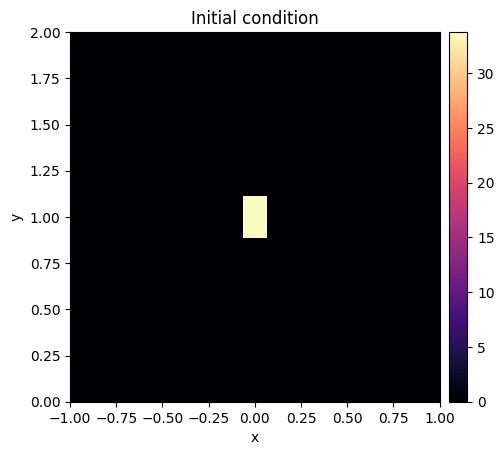

  0%|          | 0/1.0 [00:00<?, ?it/s]

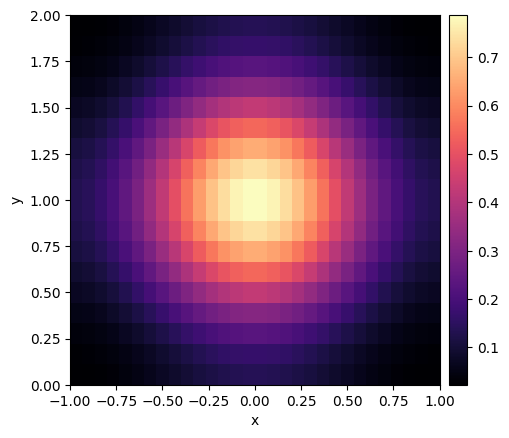

In [1]:
from pde import CartesianGrid, DiffusionPDE, ScalarField

grid = CartesianGrid([[-1, 1], [0, 2]], [30, 18])  # generate grid
state = ScalarField(grid)  # generate initial condition
state.insert([0, 1], 1)
state.plot(title="Initial condition", cmap="magma")
eq = DiffusionPDE(0.1)  # define the pde
result_pdepde = eq.solve(state, t_range=1, dt=0.001)
result_pdepde.plot(cmap="magma")
result_pdepde = result_pdepde.data

In [2]:
from examples.PyMPDATA_examples.comparison_against_pypde_2025.diffusion_2d import (
    py_pde_solution,
    InitialConditions,
)

initial_conditions = InitialConditions(
    diffusion_coefficient=0.1,
    time_step=0.001,
    time_end=1,
    grid_shape=(30, 18),
    grid_range_x=(-1.0, 1.0),
    grid_range_y=(0.0, 2.0),
    pulse_position=(0.0, 1.0),
    pulse_shape=(2, 2),
)

result_pdepde2 = py_pde_solution(initial_conditions=initial_conditions)
assert (result_pdepde == result_pdepde2).all()

  0%|          | 0/1.0 [00:00<?, ?it/s]

In [3]:
print(initial_conditions)

InitialConditions(diffusion_coefficient=0.1, time_step=0.001, time_end=1, grid_shape=(30, 18), grid_range_x=(-1.0, 1.0), grid_range_y=(0.0, 2.0), pulse_position=(0.0, 1.0), pulse_shape=(2, 2))


0.06666666666666667 0.1111111111111111
33.75


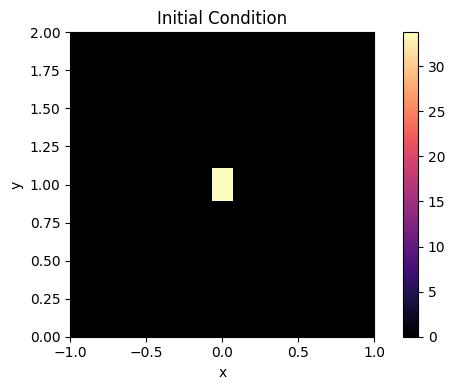

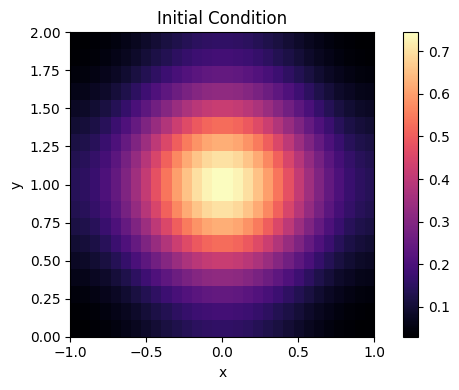

Total mass after diffusion: 1.000000 (should be close to 1)


In [4]:
import numpy as np
import matplotlib.pyplot as plt

from PyMPDATA import ScalarField, VectorField, Stepper, Solver, Options
from PyMPDATA.boundary_conditions import Periodic

# Physical and grid config
D = 0.1  # Diffusion coefficient
dt = 0.001  # Time step size
t_end = 1
nx, ny = 30, 18
min_x, max_x = -1.0, 1.0
min_y, max_y = 0.0, 2.0

dx = (max_x - min_x) / nx
dy = (max_y - min_y) / ny
print(dx, dy)
n_steps = int(t_end / dt)  # Number of time steps

# Grid: physical coordinates
x = np.linspace(min_x + dx / 2, max_x - dx / 2, nx)
y = np.linspace(min_y + dy / 2, max_y - dy / 2, ny)


# Gaussian blob initializer
def init_py_pde_like_pulse():
    data = np.zeros((nx, ny))

    # Locate cell nearest (0, 1)
    i = np.argmin(np.abs(x - 0.0))
    j = np.argmin(np.abs(y - 1.0))

    # Distribute mass over 2x2 cells (py-pde seems to do this internally)
    mass_per_cell = 1.0 / (4 * dx * dy)
    print(mass_per_cell)
    data[i, j] = mass_per_cell
    data[i + 1, j] = mass_per_cell
    data[i, j + 1] = mass_per_cell
    data[i + 1, j + 1] = mass_per_cell
    return data


# Options and stepper
opt = Options(n_iters=2, non_zero_mu_coeff=True)
stepper = Stepper(options=opt, n_dims=2)
halo = opt.n_halo  # Get required halo size

# Initialize scalar field
data = init_py_pde_like_pulse()
data_mpdata = data
advectee = ScalarField(
    data=data, halo=halo, boundary_conditions=(Periodic(), Periodic())
)

# No advection, so velocities are 0
Cx = np.zeros((nx + 1, ny), dtype=opt.dtype)
Cy = np.zeros((nx, ny + 1), dtype=opt.dtype)
advector = VectorField(
    data=(Cx, Cy), halo=halo, boundary_conditions=(Periodic(), Periodic())
)

# Create solver
solver = Solver(stepper=stepper, advector=advector, advectee=advectee)

# Plot initial blob
plt.figure(figsize=(6, 4))
plt.imshow(
    solver.advectee.get().T,
    cmap="magma",
    origin="lower",
    extent=[min_x, max_x, min_y, max_y],
)
plt.title("Initial Condition")
plt.xlabel("x")
plt.ylabel("y")
plt.colorbar()
plt.tight_layout()
plt.show()

# Run the simulation
mu_x = D * dt / dx**2
mu_y = D * dt / dy**2
# print(f"mu_x={mu_x:.3f}, mu_y={mu_y:.3f}")
solver.advance(n_steps=n_steps, mu_coeff=(mu_x, mu_y))
result_mpdata = solver.advectee.get()

# Plot final result
plt.figure(figsize=(6, 4))
plt.imshow(
    solver.advectee.get().T,
    cmap="magma",
    origin="lower",
    extent=[min_x, max_x, min_y, max_y],
)
plt.title("Initial Condition")
plt.xlabel("x")
plt.ylabel("y")
plt.colorbar()
plt.tight_layout()
plt.show()

# Total mass check
mass = np.sum(solver.advectee.get()) * dx * dy
print(f"Total mass after diffusion: {mass:.6f} (should be close to 1)")

In [5]:
from examples.PyMPDATA_examples.comparison_against_pypde_2025.diffusion_2d import (
    mpdata_solution,
)

result_mpdata2 = mpdata_solution(initial_conditions=initial_conditions)
assert (result_mpdata == result_mpdata2).all()

In [6]:
diff = result_mpdata - result_pdepde
rmse = np.sqrt(np.mean(diff**2))
l1 = np.sum(np.abs(diff)) * dx * dy
mass_py_pde = result_pdepde.sum() * dx * dy
mass_mpdata = result_mpdata.sum() * dx * dy
print("Total mass:")
print(f"py-pde:{mass_py_pde:>12.6f}")
print(f"PyMPDATA:{mass_mpdata:>10.6f}")

print(f"RMSE: {rmse:.6f}, L1 Error: {l1:.6f}")

Total mass:
py-pde:    1.000000
PyMPDATA:  1.000000
RMSE: 0.014332, L1 Error: 0.045007


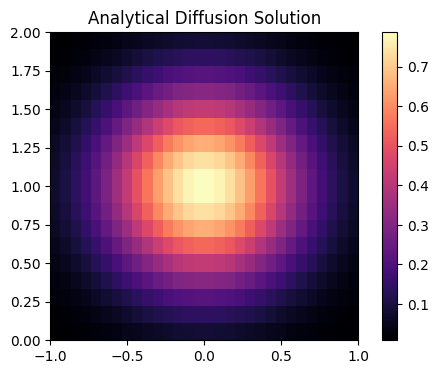

Comparison with Analytical Solution
Method                   RMSE           L1 Error
--------------------------------------------------
PDE                  0.018454           0.050680
MPDATA               0.028233           0.093632


In [7]:
def analytical_solution(x, y, t, D=0.1, center=(0.0, 1.0)):
    x0, y0 = center
    r2 = (x - x0) ** 2 + (y - y0) ** 2
    return (1 / (4 * np.pi * D * t)) * np.exp(-r2 / (4 * D * t))


X, Y = np.meshgrid(x, y, indexing="ij")
u_exact = analytical_solution(X, Y, t_end, D=D)

plt.figure(figsize=(6, 4))
plt.imshow(u_exact.T, origin="lower", extent=[min_x, max_x, min_y, max_y], cmap="magma")
plt.title("Analytical Diffusion Solution")
plt.colorbar()
plt.show()

diff_pde = result_pdepde - u_exact
rmse_pde = np.sqrt(np.mean((diff_pde) ** 2))
l1_error_pde = np.sum(np.abs(diff_pde)) * dx * dy

COL_WIDTH_METHOD = 10
COL_WIDTH_METRIC = 18

print("=" * 50)
print("Comparison with Analytical Solution")
print("=" * 50)
print(
    f"{'Method':<{COL_WIDTH_METHOD}} {'RMSE':>{COL_WIDTH_METRIC}} {'L1 Error':>{COL_WIDTH_METRIC}}"
)
print("-" * 50)
print(
    f"{'PDE':<{COL_WIDTH_METHOD}} {rmse_pde:>{COL_WIDTH_METRIC}.6f} {l1_error_pde:>{COL_WIDTH_METRIC}.6f}"
)

diff_mpdata = result_mpdata - u_exact
rmse_mpdata = np.sqrt(np.mean((diff_mpdata) ** 2))
l1_error_mpdata = np.sum(np.abs(diff_mpdata)) * dx * dy

print(
    f"{'MPDATA':<{COL_WIDTH_METHOD}} {rmse_mpdata:>{COL_WIDTH_METRIC}.6f} {l1_error_mpdata:>{COL_WIDTH_METRIC}.6f}"
)
print("=" * 50)